In [3]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F

In [4]:
with open("names.txt") as f:
    names = f.read().splitlines()

In [5]:
print(f"Num words: {len(names)}")
print(f"Min len: {min(len(w) for w in names)}")
print(f"Max len: {max(len(w) for w in names)}")
unique_chars = set(char for name in  names for char in name)
unique_chars = sorted(unique_chars)
print(f"Unique chars len: {len(unique_chars)}")
print(f"Unique chars: {unique_chars}")

Num words: 32033
Min len: 2
Max len: 15
Unique chars len: 26
Unique chars: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
symbols = ['.'] + unique_chars
stoi = {s: i for i, s in enumerate(symbols)}
itos = {i: s for s, i in stoi.items()}

In [7]:
prob_matr = torch.zeros((len(symbols), len(symbols)), dtype=torch.int)
for name in names:
    prob_matr[stoi['.'], stoi[name[0]]] += 1
    for s1, s2 in zip(name, name[1:]):
        idx1 = stoi[s1]
        idx2 = stoi[s2]
        prob_matr[idx1, idx2] += 1
    prob_matr[stoi[name[-1]], stoi['.']] += 1
prob_matr = prob_matr / prob_matr.sum(axis=1, keepdim=True)

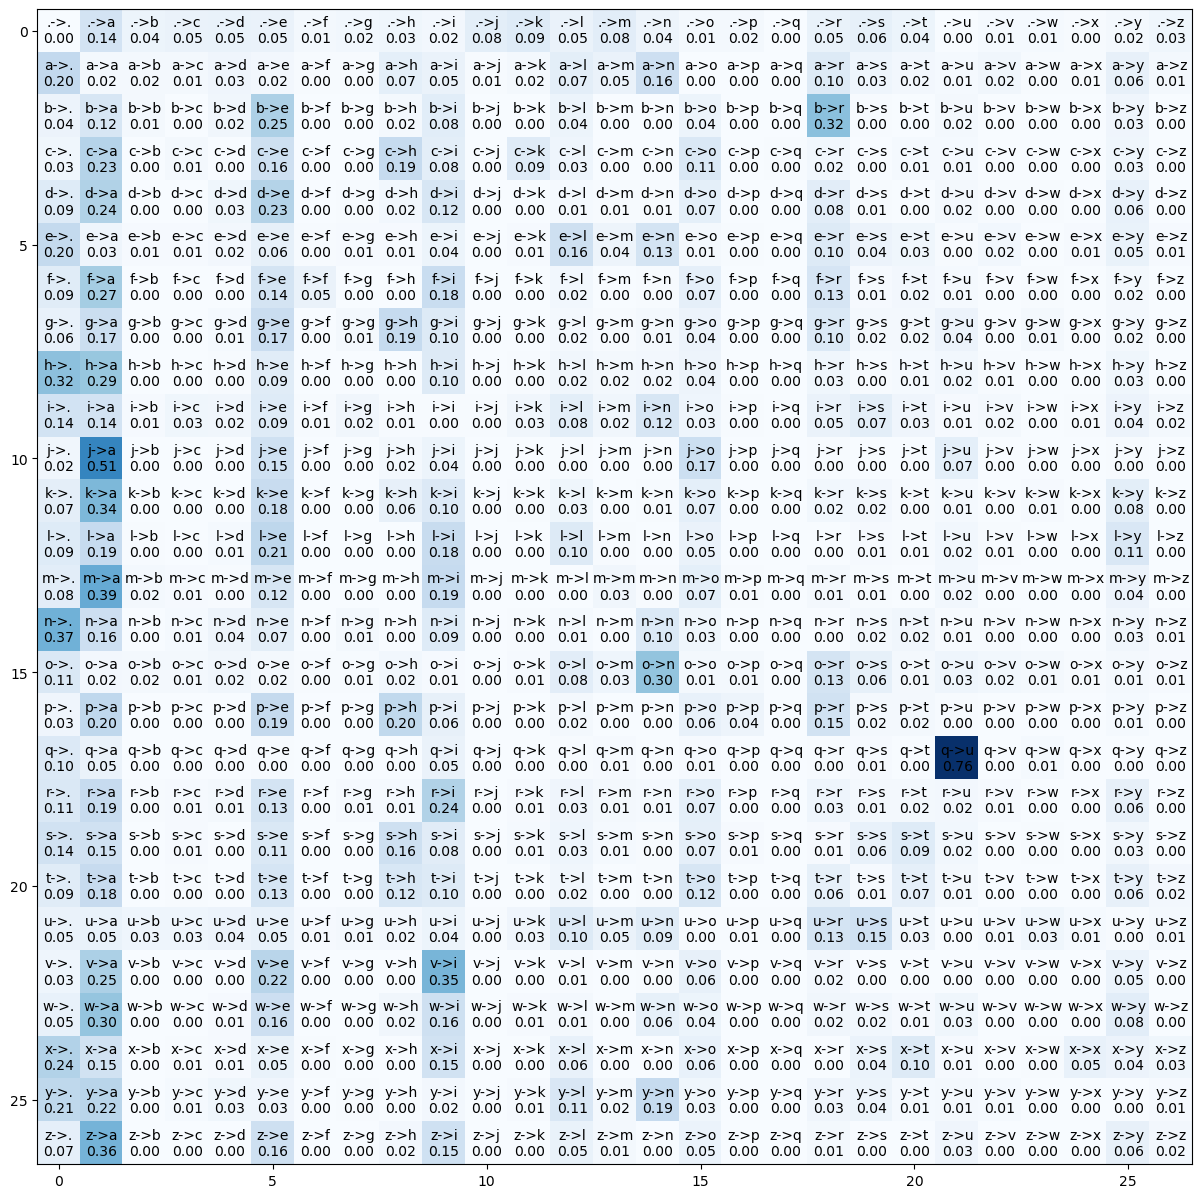

In [8]:
def plot_prob_matr(prob_matr):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(prob_matr, cmap='Blues')
    for i in range(prob_matr.shape[0]):
        for j in range(prob_matr.shape[1]):
            # text = stoi[i], stoi[j]
            transition = f"{itos[i]}->{itos[j]}"
            val = prob_matr[i, j].item()
            val = str(val) if prob_matr.dtype == torch.int else f"{val:.2f}"
            ax.text(j, i, f"{transition}\n{val}", ha='center', va='center')
    plt.show()

plot_prob_matr(prob_matr)

In [9]:
def generate_word(prob_matr) -> str:
    symbol = stoi['.']
    symbol = torch.multinomial(input=prob_matr[symbol], num_samples=1).item()
    new_word = []
    while symbol != stoi['.']:
        new_word.append(itos[symbol])
        symbol = torch.multinomial(input=prob_matr[symbol], num_samples=1).item()
    return "".join(new_word)

In [10]:
for _ in range(10):
    print(generate_word(prob_matr))


art
jaizon
sira
cash
legenistr
a
miamioniaeviada
sta
ddad
janel


$$
lik(\theta) = P(word_1, word_2, \dots, word_n | \theta) = \prod_i P(word_i | \theta) = \prod_i P(word_{ij} | \theta) = \prod_i \prod_j P(word_{i(j+1)} | word_{ij}, \theta)
$$
$$
loglik(\theta) = \sum_i \sum_j \log (P(word_{i(j+1)} | word_{ij}, \theta))
$$

In [11]:
def calc_loglik(names: List[str], prob_matr):
    loglik = 0
    n = 0
    for name in names:
        symbols = f".{name}."
        for s1, s2 in zip(symbols, symbols[1:]):
            prob = prob_matr[stoi[s1], stoi[s2]]
            loglik += torch.log(prob)
        n += len(symbols) - 1
    return (loglik / n).item()

calc_loglik(names, prob_matr)

-2.454094171524048

Train a neural net

In [12]:
class SimpleModel:
    def __init__(self):
        self._W = torch.randn(27, 27, requires_grad=True)
    def __call__(self, X):
        logits = X @ self._W
        counts = logits.exp()
        probs = counts / counts.sum(axis=1, keepdim=True)
        return probs
    def zerograd(self):
        self._W.grad = None

    def parameters(self):
        return [self._W]

In [13]:
def cross_entropy_loss(preds: torch.Tensor, hot_actuals: torch.Tensor):
    return - preds[np.arange(hot_actuals.shape[0]), np.argmax(hot_actuals, axis=1)].log().mean()
    loglik = 0
    for sample_idx in range(hot_actuals.shape[0]):
        true_idx = (hot_actuals[sample_idx] == 1).nonzero(as_tuple=True)[0][0]
        loglik = loglik - preds[sample_idx][true_idx].log()
    return loglik / preds.shape[0]

In [14]:
X = sum((['.'] + list(name) for name in names), [])
y = sum((list(name) + ['.'] for name in names), [])
X = torch.tensor([stoi[s] for s in X])
y = torch.tensor([stoi[s] for s in y])
X = F.one_hot(X, num_classes=27).float()
y = F.one_hot(y, num_classes=27)


In [15]:
X_train = X
y_train = y

In [16]:
sm = SimpleModel()

In [23]:
# training loop
NUM_ITERS = 100

optimizer = torch.optim.Adam(sm.parameters(), lr=0.01)

for _ in range(NUM_ITERS):
    probs = sm(X_train)
    loss = cross_entropy_loss(probs, y_train)
    print(loss.item())

    sm.zerograd()
    loss.backward()

    optimizer.step()

2.4541425704956055
2.454151153564453
2.4541409015655518
2.454141139984131
2.454141855239868
2.4541373252868652
2.454132556915283
2.454129457473755
2.4541289806365967
2.4541282653808594
2.4541258811950684
2.454122543334961
2.454120397567749
2.4541189670562744
2.454118251800537
2.4541168212890625
2.4541149139404297
2.4541127681732178
2.454111337661743
2.4541101455688477
2.4541091918945312
2.4541079998016357
2.454106092453003
2.4541046619415283
2.454103708267212
2.4541025161743164
2.4541015625
2.4541001319885254
2.45409893989563
2.4540979862213135
2.454096794128418
2.4540960788726807
2.454094886779785
2.4540939331054688
2.4540929794311523
2.454091787338257
2.4540910720825195
2.4540903568267822
2.454089403152466
2.4540886878967285
2.454087495803833
2.4540867805480957
2.4540858268737793
2.454085350036621
2.4540843963623047
2.4540836811065674
2.454082489013672
2.4540822505950928
2.4540815353393555
2.454080581665039
2.4540798664093018
2.4540793895721436
2.4540786743164062
2.454078197479248
2.

In [24]:
def generate_word_with_nn(model: SimpleModel):
    probs = model(F.one_hot(torch.tensor([stoi['.']]), num_classes=27).float())
    idx = torch.multinomial(probs, 1)[0].item()
    word = []
    while idx != stoi['.']:
        char = itos[idx]
        word.append(char)
        probs = model(F.one_hot(torch.tensor([idx]), num_classes=27).float())
        idx = torch.multinomial(probs, 1)[0].item()
    
    return ''.join(word)

In [26]:
for _ in range(10):
    print(generate_word_with_nn(sm))

deunalevi
tratr
acaliahy
joharr
linn
caleyn
ck
jo
r
lvroron
